In [20]:
import math
import torch
import matplotlib.pyplot as plt

In [21]:
# 학습용 데이터
x = torch.linspace(-math.pi, math.pi,1000)
# 정답
y = torch.sin(x)

In [22]:
# 3차 다항식
# f(x) = ax**3 + bx**2 + cx + d
# 초기화
a,b,c,d = torch.randn(()),torch.randn(()),torch.randn(()),torch.randn(())
y_random = a*x**3 + b*x**2 + c*x + d

ValueError: x and y must have same first dimension, but have shapes (1000,) and (100, 1)

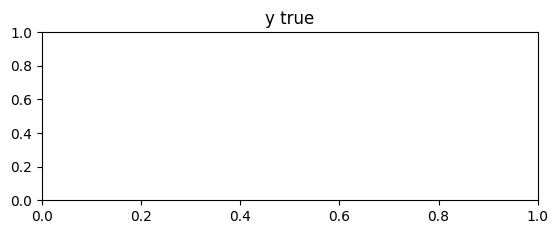

In [57]:
# 시각화
# 1. 실제값 시각화 = 정답값 3차원 수식
plt.subplot(2,1,1)
plt.title('y true')
plt.plot(x,y)   #x는 임의의 값, y는 실제 sin값

# 2. 임의의 가중치로 만든 예측용 값으로 시각화
plt.subplot(2,1,2)
plt.title('y random')
plt.plot(x,y_random)

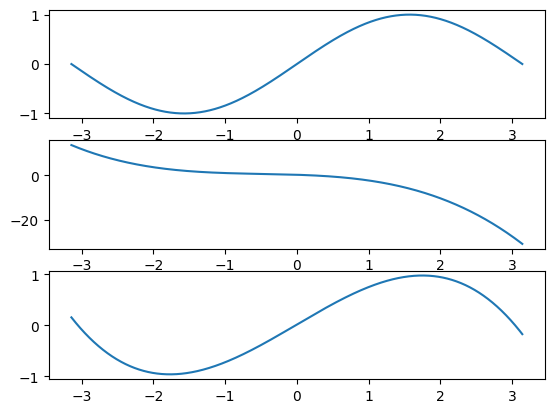

In [24]:
# 파라메터 정의
learning_rate = 1e-6
total_loss = []
for epoch in range(2000):
    # 전체 학습과정을 몇번 반복할것인지. 
    # 전체 데이터 학습 1회 = epoch
    # 즉 a,b,c,d를 2000번 업데이트 하겠다는 의미
    # forward : 아까 만든 3차원 방정식에 x값을 넣고 a,b,c,d값을 넣겠다는 의미
    y_pred =  a*x**3 + b*x**2 + c*x + d     # 모델

    # 손실을 계산하기 위해서는 손실을 정의해야한다. 
    # MSE 평균 제곱오차가 필요
    # 오차를 제곱하는 이유는 음수를 방지하기 위함이다.
    # 음수를 방지하여 크기만 보도록 하기 위해
    # 오차가 큰 값에 더 큰 패널티를 부여하기 위해서
    loss = torch.sqrt((y_pred - y)**2).mean().item()    # 텐서에 저장된 숫자값만 추출(그래프 추적을 피함)

    total_loss.append(loss)
    #if epoch % 100 == 0:
    #    print(f'epoch{epoch+1} :  loss : {loss}')

    # 역전파 계산(BackPropagation) loss 줄이기 위해서 a,b,c,d 어느 방향으로 움직여야 할 지 계산
    # 미분
    grad_y_pred = 2.0*(y_pred - y)  # 기울기의 미분값
    grad_a = 2.0*(grad_y_pred*x**3).sum()   # 기울기의 각각의 미분값을 모두 더함
    grad_b = 2.0*(grad_y_pred*x**2).sum()
    grad_c = 2.0*(grad_y_pred*x).sum()
    grad_d = 2.0*(grad_y_pred).sum()

    # 가중치 업데이트
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

plt.subplot(3,1,1)
plt.plot(x,y)           # 실제값
plt.subplot(3,1,2)
plt.plot(x,y_random)    # 랜덤값
plt.subplot(3,1,3)
plt.plot(x,y_pred)      # 학습값


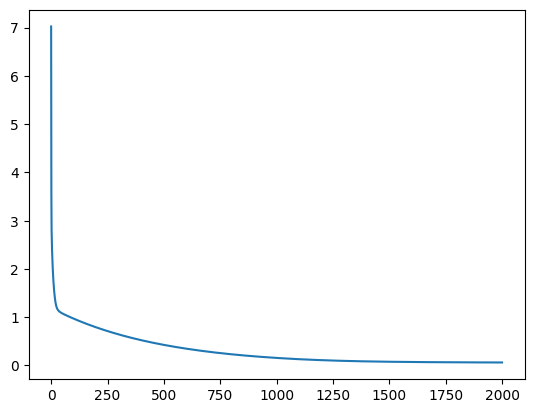

In [28]:
plt.plot(range(2000), total_loss)

D-loss / D-a
D-loss / D-b
D-loss / D-c
D-loss / D-d

loss는 파라메터들과 직접 연관이 없음
다만 다음과 같은 연쇄구조를 가진다(chain)

a,b,c,d -> y_pred를 예측해서 -> loss
손실함수 loss 자체는 
loss = (y_pred - loss)

D-loss / D-a = ( D-ypred / D-a ) * ( D-loss / D-y_pred )


D-ypred / D-a = x ** 3

D-loss / D-y_pred = 2 * (y_pred - y)

In [ ]:
# 회귀 모델 by Deeplearning
# 보스턴 집값 예측하기
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [47]:
# pytorch
# 미분을 자동으로 계산
# 계산된 미분을 optimizer를 통해 적용 : 최적화 알고리즘
import torch
import torch.nn as nn
from torch.optim.adam import Adam
# 모델 정의
model = nn.Sequential(
    nn.Linear(data.shape[1] , 100),  # 13의 데이터를 입력받아서 결과를 100개 즉 100개를 예측
    nn.ReLU(),
    nn.Linear(100, 1)  # 100개의 예측결과를 받아서 최종 1개를 예측
)

# 하이퍼 파라메터 정의
batch_size = 100
learning_rate = 1e-03  # 0.001

# 옵티마이져 정의
optim = Adam(model.parameters(), lr=learning_rate)
target = target.reshape(-1,1)
# 학습루프 만들기
for epoch in range(200):
    for i in range(len(data)//batch_size):     #506개 데이터 중 100개씩 5번 학습시키겠다는 뜻
        start = i*batch_size
        end = start + batch_size
        X = torch.FloatTensor(data[start:end])
        y = torch.FloatTensor(target[start:end])

        optim.zero_grad()   #학습이후 다음 학습에 이전 가중치가 계산되는 것을 방지
        preds = model(X)    # 순전파 ..forward 
        loss = nn.MSELoss()(preds,y)    #preds와 정답의 shape가 같아야함
        loss.backward()     #기울기 계산 ..backward 각 파라메터의 그레이던트를 자동으로 계산 .grad 저장
        optim.step()        #옵티마이져가 .grad 정보를 사용해서 파라메터를 갱신
    if epoch % 20 == 0:
        print(f'epoch : {epoch + 1} : loss : {loss.item()}')    #에포크의 가장 마지막 batch 출력(평균)
    


epoch : 1 : loss : 169.79629516601562
epoch : 21 : loss : 21.52570343017578
epoch : 41 : loss : 18.44474983215332
epoch : 61 : loss : 16.77735137939453
epoch : 81 : loss : 15.535724639892578
epoch : 101 : loss : 14.599165916442871
epoch : 121 : loss : 13.955911636352539
epoch : 141 : loss : 13.506921768188477
epoch : 161 : loss : 13.17618179321289
epoch : 181 : loss : 13.552952766418457


# 순전파 : X -> model -> preds -> loss
# 역전파 : dloss/dpreds 계산해서 각 선형층의 파라메터(가중치, 편향)으로 전파
```
loss.backward() 호출되어서 pytorch autograd가 연쇄법칙(chain rule)을 이용해서 각 파라메터의 .grad를 채움
optim.step() : .grad를 읽어서 파라메터를 갱신

ReLu(활성화 함수) : max(0,z) 
z가 음수이면 0, 양수면 그대로 전달
역전파 
    - z > 0 : dReLu(z)/dz = 1
    - z <= 0 dReLu(z)/dz = 0
    - 비선형을 제공해서 계산이 간단해진다
    - 기울기 소실이 sigmoid나 tanh(하이포그릭탄젠트) 보다 유리하다
    - 음수이면 0이니까.. 일부 뉴런이 비활성화되어 표현이 희소해진다.
        -> LeekyReLU

Adam : 옵티마이져
    - 모멘텀과 스케일 조정이라는 두가지 방법을 결합한 것
    - 적응적 학습률 : 파라메터별로 학습률을 조정 -> 초기값 안정적
    - 빠른 수령 : SGD보다 빠름
    - 튜닝이 거의 필요없음..기본 파라메터가 lr = 0.001도 좋은 성능
    - 단점 : 과적합이 다른 최적화 모델에 비해 발생하기 쉬운 구조
```

```
옵티마이져 : 모델 파라메터를 손실이 줄어들게 갱신하는 역할
P_t : 현재 파라메터
n : 학습률
gt : 현재 그레이디언트

p_t+1 = p+t - n*gt
단점 : 
    기울기가 둘쑥날쑥(노이즈에 약하다)
    모든 파라메터가 같은 학습률을 적용(비효율적)
    --> 그래서 나온게 모멘텀, 스케일 조정이다.

모멘텀(Momentum):
    이전 기울기의 방향을 "기억"해서 관성처럼 부드럽게 이동하는 기법
    vi : 누적된 속도 또는 1차 모멘트
    gt : 현재 그레이디언트
    b1 : 모멘텀의 갯수(보통은 0.9)
    n : 학습률
    vt = b1vt-1 + (1-b1)gt
        pt+1 = pt - n*vt
시점
    t : 1   단순히 g1을 따라감
    t : 2   이전 속도 v1의 일부를 남겨서 새로운 방향에 더해줌
    t -> infinite 여러 스텝 동안 방향이 일정하면 점점 가속이 되어 빠르게 수렴
기울기가 변해도 관성때문에 부드럽게 움직인다.

스케일(Scale) 조정:
    파라메터의 기울기의 크기를 고려해서 학습률을 자동으로 조정
    과거 파라메터의 크기를 추적해서 큰 변동이 있었던 파라메터는 작게,
    작은 변동은 크게 이동시킨다.

아담(Adam) : 모멘텀 + 스케일 조정 하이브리드 방식
    step 1 : 모멘텀
    step 2 : 스케일 조정
    step 3 : 바이서 보정 (초기 스텝에서는 m,v=0 보정)
    step 4 : 최종 업데이트 - 모멘텀으로 얻은 방향 + 스케일 조정된 학습률로 이동을 시켜나감

SGD                     단순히 그레이디언트                          진동심함, 느림
Momentum                과거방향의 관성사용                          진동완화, 빠른수렴
RMSProb/ AdaGrad        그레이디언트 제곱의 평균으로 스케일 조정      파라메터별 자동학습률
Adam                    모멘텀 + RMSProm 결합                       기본설정도 훌륭함

```

In [55]:
# 모델의 성능 평가 : 예측
print(data.shape, target.shape)
predict = model(torch.FloatTensor(data)).detach().numpy()
predict.shape, target.shape

(506, 13) (506, 1)


((506, 1), (506, 1))

In [56]:
from sklearn.metrics import r2_score
r2_score(target, predict)

0.6704806431979271

In [ ]:
# 적절한 머신러닝 알고리즘으로 비교 평가
